In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint,RK45,solve_ivp

In [48]:
def get_E_v(t,alp,beta,sigma,v0):
    res = np.exp(-beta*t)*(v0 - alp/beta) + alp/beta
    return res

def get_E_vAvB(t,alp,beta,sigma,v0):
    res = np.exp(-beta*t)*(v0 - alp/beta) + alp/beta
    return res.prod()

def get_E_svAvB(t,alpha,beta,sigma,v0):
    E_v = get_E_v(t,alpha,beta,sigma,v0)
    sEvAvB = np.sqrt(E_v.prod())
    var_v = get_V_v(t,alpha,beta,sigma,v0)
    res = sEvAvB + 1.0/sEvAvB*-0.125*(var_v[0]*E_v[1]/E_v[0] + var_v[1]*E_v[0]/E_v[1])
    return res

def get_V_v(t,alpha,beta,sigma,v0):
    ex = np.exp(-beta*t)
    return np.power(sigma,2)/beta*(1.0-ex)*(v0*ex+alpha/(2.0*beta)*(1.0-ex))

In [3]:
v0 = np.array([0.018,0.013])
alpha = np.array([0.021,0.015])
beta = np.array([1.279,1.115])
sigma = np.array([0.232,0.099]) # volatility of variance
rho = 0.903
# rho = 0.0
correlation = np.matrix([[1, rho],[rho,1]])
L = np.linalg.cholesky(correlation)

In [4]:
# simulation parameters
np.random.seed(1)
T = 30
num_steps = int(T*500)
num_paths = 7500
# num_paths = 15000
res = np.zeros((num_steps, num_paths)) # vAvB
dt = T/num_steps
t_sim = np.linspace(0.0,T,num_steps+1)
# Initialize states

v = np.zeros([num_steps+1, len(v0), num_paths])

# Initialization
for j in range(len(v0)):
    v[0,j,:] = v0[j]
    
for i in range(num_steps):
    # Volatility
    dW_indep = np.random.normal(0.0,1.0,(2,num_paths))
    dW_indep = (dW_indep-dW_indep.mean(axis=1).reshape(-1,1))/dW_indep.std(axis=1).reshape(-1,1) # normalize
    dW = L*dW_indep*np.sqrt(dt) # each row (sA sB vA vB) 
#     dW   = np.random.multivariate_normal([0,0,0,0], p["correlation"], num_paths).transpose()*np.sqrt(dt)
    for j in range(len(v0)): # j in (A,B)
        drift_term = (alpha[j] - beta[j]*v[i,j,:])*dt
        dWv = dW[j,:] # A or B
        vol_term = sigma[j]*np.multiply(np.sqrt(v[i,j,:]),dWv)
        vol_term += 0.25*sigma[j]**2.0 * (np.power(dWv,2) - dt) # Milstein term
        v[i+1,j,:] = np.maximum(0.0,v[i,j,:] + drift_term + vol_term) # truncation


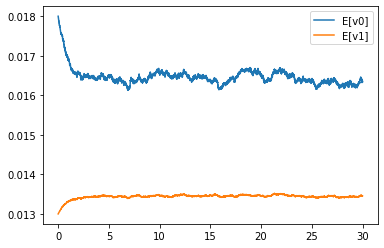

In [5]:
plt.plot(t_sim,v[:,0,:].mean(axis=1),label='E[v0]')
plt.plot(t_sim,v[:,1,:].mean(axis=1),label='E[v1]')
plt.legend()

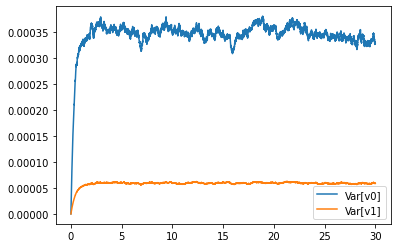

In [6]:
plt.plot(t_sim,v[:,0,:].var(axis=1),label='Var[v0]')
plt.plot(t_sim,v[:,1,:].var(axis=1),label='Var[v1]')
plt.legend()

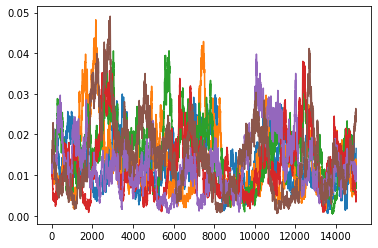

In [7]:
ind = [1,5,10,20,30,50]
plt.plot(v[:,1,ind])

# Expectation of the square root of vAvB

In [55]:
def get_cov_vAvB(t,alpha,beta,sigma,rho,v0):
    y0 = 0.0
    E_v = get_E_v(t,alpha,beta,sigma,v0)
    sEvAvB = np.sqrt(E_v.prod())
    var_v = get_V_v(t,alpha,beta,sigma,v0)
    const = sEvAvB -0.125/sEvAvB*(var_v[0]*E_v[1]/E_v[0] + var_v[1]*E_v[0]/E_v[1])
    A = (-beta.sum() + 0.25*sigma.prod()*rho/sEvAvB)
    B = const*sigma.prod()*rho
    res =  B/A*(np.exp(A*t)-1)
    return res

def get_E_svAvB_2(t,alpha,beta,sigma,rho,v0):
    cov = get_cov_vAvB(t,alpha,beta,sigma,rho,v0)
    E_v = get_E_v(t,alpha,beta,sigma,v0)
    sEvAvB = np.sqrt(E_v.prod())
    var_v = get_V_v(t,alpha,beta,sigma,v0)
    res = sEvAvB + 1.0/sEvAvB*(0.25*cov -0.125*(var_v[0]*E_v[1]/E_v[0] + var_v[1]*E_v[0]/E_v[1]))
    return res

In [56]:
EsvAvB = np.zeros(v.shape[0])
approx1 = np.zeros(v.shape[0])
approx2 = np.zeros(v.shape[0])
approx3 = np.zeros(v.shape[0])
for i in range(v.shape[0]):
    t = t_sim[i]
    EsvAvB[i] = np.mean(np.sqrt(v[i,:,:].prod(axis=0)))
    approx1[i] = np.sqrt(get_E_vAvB(t,alpha,beta,sigma,v0))
    approx2[i] = get_E_svAvB(t,alpha,beta,sigma,v0)
    approx3[i] = get_E_svAvB2(t,alpha,beta,sigma,rho,v0)

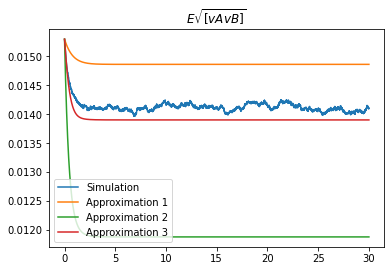

In [57]:
plt.plot(t_sim,EsvAvB,label='Simulation')
plt.plot(t_sim,approx1,label='Approximation 1')
plt.plot(t_sim,approx2,label='Approximation 2')
plt.plot(t_sim,approx3,label='Approximation 3')
plt.title('$E\sqrt{[vAvB]}$')
plt.legend()

In [10]:
# How about we take correlation b.t.w. Brownian motions into account?

In [37]:
def get_cov_grad(t,y0,alpha,beta,sigma,rho,v0):
    E_v = get_E_v(t,alpha,beta,sigma,v0)
    sEvAvB = np.sqrt(E_v.prod())
    var_v = get_V_v(t,alpha,beta,sigma,v0)
    const = sEvAvB -0.125/sEvAvB*(var_v[0]*E_v[1]/E_v[0] + var_v[1]*E_v[0]/E_v[1])
    res =  (-beta.sum() + 0.25*sigma.prod()*rho/sEvAvB)*y0[0] + const*sigma.prod()*rho
    return [res]

args = (alpha,beta,sigma,rho,v0)
grad_RK45 = lambda t,y: get_cov_grad(t,y,*args)
y0 = [0.0]
sol= solve_ivp(grad_RK45,[t_sim[0],t_sim[-1]], y0, t_eval=t_sim,rtol = 1e-5,first_step=1e-8)


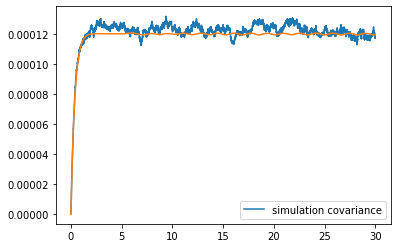

In [38]:
sim_cov = [np.cov(v[i,0,:],v[i,1,:])[0,1] for i in range(len(t_sim))]
plt.plot(t_sim,sim_cov,label='simulation covariance')
plt.plot(t_sim,sol.y.reshape(-1))
plt.legend()

In [51]:
get_cov_vAvB(30,alpha,beta,sigma,rho,v0)

0.00012042175797684159

0.903